# Auduo transcription, grammar correction and grammar analysis
Celular: +57 3202347640
Correo: p.r.and@hotmail.com
LinkedIn: https://www.linkedin.com/in/andresparrarod/


Resumen

Pipeline Sugerido:
    1. Transcripcion "raw"
    2. Extracción 5 fragmentos reprepsentativos (30s-60s) y transcripcion manual
    3. transcript_raw → transcript_corrected
    4. Evaluacion
    5. Insights

Anotaciones
- Es como que hay una coversacion entre un profesor y un estudiante
- Para transcripciones Wisper es gratis y local. Google Speech-to-Text (STT) es Gratis con límites. Azure igual


## 1. Fragmentacion y obtencion gold

### 1.0. Carga de librerías y reubicación del path para que trabaje con carpetas de git

In [2]:
from pydub import AudioSegment
import pandas as pd
import math
import os
from jiwer import wer, cer
import whisper
from transformers import pipeline
import whisperx
import matplotlib.pyplot as plt
import numpy as np
from difflib import ndiff
from collections import Counter

# ---------------------------------------- Ubicación del path en ruta origen
# Directorio actual del notebook
notebook_dir = os.getcwd()
# Retrocede un nivel hasta el repositorio
repo_path = os.path.normpath(os.path.join(notebook_dir, ".."))
# Cambia al directorio del repositorio
os.chdir(repo_path)

In [3]:
import os
print(os.getcwd()) 

c:\Users\prand\OneDrive\Escritorio\Postulaciones Trabajo\Solvo\test git


### 1.1. Fragmentacion y obtencion gold

This script loads an audio file (audio_full.m4a) using pydub, calculates its total duration, and divides it into 30‑second segments, excluding certain clips that are not relevant for transcription. Each segment is exported as an individual .m4a file into a fragmentos folder, and a DataFrame (dfCrops) records the start and end times of each fragment. A filtered version of this DataFrame (gold0) removes clips that won’t be transcribed (based on listaNOTrans) and prepares a “gold set” CSV file (transcript_gold.csv) with empty transcript and speaker fields to be filled in manually later. The script ensures the CSV is only created if it doesn’t already exist to prevent overwriting manual work.

In [5]:
# Cargar audio
audio = AudioSegment.from_file("data/raw/audio_full.m4a")

# Duración total en milisegundos
duracion_ms = len(audio)
# Duración de fragmentos en milisegundos (30 segundos)
fragmento_ms = 30 * 1000
# Número de fragmentos (-1 debido a que hay unos datos que no corresponden a audio)
num_fragmentos = math.ceil(duracion_ms / fragmento_ms) - 1
# Crear carpeta de salida
os.makedirs("fragmentos", exist_ok=True)
dfCrops = pd.DataFrame()
# Cortar y guardar fragmentos
for i in range(num_fragmentos):
    if i==0:
        inicio = i * fragmento_ms
    else:
        inicio = i * fragmento_ms + 1
    fin = (i + 1) * fragmento_ms
    fragmento = audio[inicio:fin]
    fragmento.export(f"data/stage/fragmentos/audio_parte_{i}.m4a", format="ipod")
    dfCrops.loc[i, "clip_id"] = i
    dfCrops.loc[i, "start_time"] = inicio
    dfCrops.loc[i, "end_time"] = fin

# Indices fragmentos para transcribir
listaNOTrans = [0, 2, 4, 6, 8]
# Preparacion df gold para guardarlo
gold0 = dfCrops.copy()
gold0["transcript_gold"] = ""
gold0["speaker"] = ""
gold0 = gold0.drop(listaNOTrans)
# Nombre del archivo
csv_file = "data/stage/transcript_gold.csv"
# Verifica si el archivo existe para no sobreescribirlo, ya que se llena luego a mano
if not os.path.exists(csv_file):
    # Guardar como CSV
    gold0.to_csv(csv_file, index=False, sep=';', encoding='utf-8')
    print(f"Archivo creado: {csv_file}")
else:
    print(f"El archivo ya existe: {csv_file}")

El archivo ya existe: data/stage/transcript_gold.csv


## 2. Transcripción fragmentos

2.1. Función para evaluación de resultados

This function only calculates the CER and WER metrics. It can evaluate how much a text looks like the other.

In [6]:
def werCerDf(dfGR):
    # Calcular WER y CER para cada fila
    results = []
    for idx, row in dfGR.iterrows():
        gold = row["transcript_gold"]
        raw = row["transcript_raw"]
        corr = row["transcript_raw_corr"]
        wer_raw = wer(gold, raw)
        wer_corr = wer(gold, corr)
        cer_raw = cer(gold, raw)
        cer_corr = cer(gold, corr)
        results.append({
            "audio_id": row["audio_id"],
            "WER_raw": wer_raw,
            "WER_corr": wer_corr,
            "CER_raw": cer_raw,
            "CER_corr": cer_corr,
            "WER_mejora_%": 100 * (wer_raw - wer_corr) / wer_raw if wer_raw != 0 else 0,
            "CER_mejora_%": 100 * (cer_raw - cer_corr) / cer_raw if cer_raw != 0 else 0,
        })
    # Convertir a DataFrame
    df_resultados = pd.DataFrame(results)
    # Mostrar tabla
    print('\n')
    print(df_resultados[["audio_id", "WER_raw", "WER_corr", "CER_raw", "CER_corr", "WER_mejora_%", "CER_mejora_%"]].round(2))
    print(f"\nWER_mejora_%: {df_resultados['WER_mejora_%'].mean():.2f}")
    print(f"CER_mejora_%: {df_resultados['CER_mejora_%'].mean():.2f}")
    print(f"WER_raw_mean: {df_resultados['WER_raw'].mean():.2f}")
    print(f"CER_raw_mean: {df_resultados['CER_raw'].mean():.2f}")
    print(f"WER_corr_mean: {df_resultados['WER_corr'].mean():.2f}")
    print(f"CER_corr_mean: {df_resultados['CER_corr'].mean():.2f}")
    return df_resultados

### 2.1. Transcripción sin diarizacion

Firts we have to trancript our audio to text. this is made only in 5 audios.

In [20]:
# Cargar modelo (Se puede usar: tiny, base, small, medium, large)
model = whisper.load_model("large")
# Indices fragmentos para transcribir
listaTrans = [1, 3, 5, 7, 9]
dfRaw = pd.DataFrame()
for i in listaTrans:
    # Transcribir el audio
    result = model.transcribe(f"data/stage/fragmentos/audio_parte_{i}.m4a")
    # Agrupa y guarda lo transcrito
    text = result["text"]
    dfRaw.loc[i, "audio_id"] = i
    dfRaw.loc[i, "transcript_raw"] = text

# Guarda en CSV
dfRaw.to_csv("data/stage/transcript_raw.csv", index=False, sep=';', encoding='utf-8')
print(dfRaw.head())

   audio_id                                     transcript_raw
1       1.0   small break tomorrow because it's a holiday i...
3       3.0   classes so I I don't think they're they would...
5       5.0   first you maybe go on to a fancy brunch. Brun...
7       7.0   still have one more you know day for me to fi...
9       9.0   Alright. Or for example, one hour short. Do y...


After the transcription we have to correct the grammar mistakes made by the algorithm

In [21]:
# Lectura del df gold
dfGold = pd.read_csv("data/stage/transcript_gold.csv", sep=';', encoding='utf-8-sig')
# Unión del gold junto con lo transcrito (raw)
dfGR = pd.merge(dfRaw, dfGold, left_on='audio_id', right_on='clip_id', how='inner')

# Carga pipeline de corrección (inglés)
corrector = pipeline("text2text-generation", model="vennify/t5-base-grammar-correction")
# Funcion de corrección por fila
def corregir(texto):
    if pd.isna(texto) or not isinstance(texto, str):
        return texto
    resultado = corrector(f"fix: {texto}", max_length=512)[0]['generated_text']
    return resultado
# Asume que la columna con errores se llama 'transcript_raw'
dfGR["transcript_raw_corr"] = dfGR["transcript_raw"].apply(corregir)

# Calculo der WER CER con funcion
df_resultados = werCerDf(dfGR)
# Guardado mejor resultado para gráficas
df_resultados_mejor = df_resultados.copy()
dfGR_final = dfGR.copy()

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_



   audio_id  WER_raw  WER_corr  CER_raw  CER_corr  WER_mejora_%  CER_mejora_%
0       1.0     0.29      0.25     0.20      0.20         15.79         -1.39
1       3.0     0.46      0.43     0.29      0.30          8.00         -6.59
2       5.0     0.40      0.44     0.22      0.24         -9.52         -7.94
3       7.0     0.60      0.58     0.40      0.39          2.70          3.23
4       9.0     0.16      0.15     0.09      0.06         11.11         34.62

WER_mejora_%: 5.62
CER_mejora_%: 4.38
WER_raw_mean: 0.38
CER_raw_mean: 0.24
WER_corr_mean: 0.37
CER_corr_mean: 0.24


### 2.2. Transcripcion con diarizacion

This script uses WhisperX for speaker diarization and Whisper for transcription of selected audio fragments. It loads a diarization model (authenticated via a Hugging Face token) and a base Whisper transcription model. For specific audio clips listed in listaTrans, the script detects two speakers, segments their speech, and exports each segment for transcription. The transcribed text is concatenated and stored in a DataFrame (dfRaw) alongside the clip ID. Finally, all raw transcriptions are saved to transcript_raw.csv for further processing.

In [9]:
# Cargar modelo
modelDiar = whisperx.load_model("base", device="cpu", language="en", compute_type="float32")
# Carga de token de Hugging Face
with open("HFtoken.txt") as f:
    hf_token = f.read().strip()
diarize_model = whisperx.diarize.DiarizationPipeline(use_auth_token=hf_token)

    
# Cargar modelo (Se puede usar: tiny, base, small, medium, large)
modelTrans = whisper.load_model("base")
# Indices fragmentos para transcribir
listaTrans = [1, 3, 5, 7, 9]
dfRaw = pd.DataFrame()
for i in listaTrans:
    # Diarizacion
    diarization = diarize_model(f"data/stage/fragmentos/audio_parte_{i}.m4a", num_speakers=2)
    # Cargar audio
    audio = AudioSegment.from_file(f"data/stage/fragmentos/audio_parte_{i}.m4a")
    textOut = str()
    # Cortar y guardar fragmentos
    for f in range(len(diarization)):
        inicio = int(diarization.loc[f, 'start'] * 1000)
        fin = int(diarization.loc[f, 'end'] * 1000)
        fragmento = audio[inicio:fin]
        fragmento.export(f"temp/fragmentos_temp.m4a", format="ipod")
        # Transcripción + alineación temporal
        result = modelTrans.transcribe('temp/fragmentos_temp.m4a')
        text = result["text"]
        # textOut = textOut + diarization.loc[f, 'speaker'] + ': ' + text + ".n\ "
        textOut += text + "."
    
    dfRaw.loc[i, "audio_id"] = i
    dfRaw.loc[i, "transcript_raw"] = textOut

# Guarda en CSV
dfRaw.to_csv("data/stage/transcript_raw.csv", index=False, sep=';', encoding='utf-8')

c:\Users\prand\.conda\envs\python3.9\lib\site-packages\ctranslate2\__init__.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Users\prand\.conda\envs\python3.9\lib\inspect.py:746: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\prand\.conda\envs\python3.9\lib\site-packages\whisperx\assets\pytorch_model.bin`


>>Performing voice activity detection using Pyannote...
Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.1+cu118. Bad things might happen unless you revert torch to 1.x.


c:\Users\prand\.conda\envs\python3.9\lib\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


In [12]:
# Lectura del df gold
dfGold = pd.read_csv("data/stage/transcript_gold.csv", sep=';', encoding='utf-8-sig')
# Unión del gold junto con lo transcrito (raw)
dfGR = pd.merge(dfRaw, dfGold, left_on='audio_id', right_on='clip_id', how='inner')

# Carga pipeline de corrección (inglés)
corrector = pipeline("text2text-generation", model="vennify/t5-base-grammar-correction")
# Funcion de corrección por fila
def corregir(texto):
    if pd.isna(texto) or not isinstance(texto, str):
        return texto
    resultado = corrector(f"fix: {texto}", max_length=512)[0]['generated_text']
    return resultado
# Asume que la columna con errores se llama 'transcript_raw'
dfGR["transcript_raw_corr"] = dfGR["transcript_raw"].apply(corregir)

# Calculo der WER CER con funcion
df_resultados = werCerDf(dfGR)

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_



   audio_id  WER_raw  WER_corr  CER_raw  CER_corr  WER_mejora_%  CER_mejora_%
0       1.0     0.69      0.69     0.53      0.57          0.00         -7.25
1       3.0     0.72      0.52     0.55      0.38         28.21         31.64
2       5.0     1.12      1.12     0.80      0.80          0.00          0.44
3       7.0     0.50      0.47     0.41      0.34          6.45         17.32
4       9.0     0.65      0.60     0.40      0.38          8.33          6.61

WER_mejora_%: 8.60
CER_mejora_%: 9.75
WER_raw_mean: 0.74
CER_raw_mean: 0.54
WER_corr_mean: 0.68
CER_corr_mean: 0.49


## 3. Correccion fragmentos con diferentes modelos

Se hacen pruebas con distintos modelos para la corriección. Se realiza con el algorítmo que no emplea diarización debido a que presenta menor error CER y WER

In [13]:
# Cargar modelo (Se puede usar: tiny, base, small, medium, large)
model = whisper.load_model("large")
# Indices fragmentos para transcribir
listaTrans = [1, 3, 5, 7, 9]
dfRaw = pd.DataFrame()
for i in listaTrans:
    # Transcribir el audio
    result = model.transcribe(f"data/stage/fragmentos/audio_parte_{i}.m4a")
    # Agrupa y guarda lo transcrito
    text = result["text"]
    dfRaw.loc[i, "audio_id"] = i
    dfRaw.loc[i, "transcript_raw"] = text

# Guarda en CSV
dfRaw.to_csv("data/stage/transcript_raw.csv", index=False, sep=';', encoding='utf-8')

Modelo: vennify/t5-base-grammar-correction

Basado en T5 (Text-to-Text Transfer Transformer) de Google. Aquí tienes una descripción clara:

Tipo de modelo
Base: t5-base (220M parámetros)
Arquitectura: Encoder-Decoder (Text-to-Text)
Entrenado para: Corrección gramatical en inglés
Enfoque: Dado un texto de entrada con errores, el modelo genera una versión corregida.
Ejemplo de entrada: "fix: she no went to the market."
Salida: "she did not go to the market."

In [14]:
# MODELO BASE SIN BUSQUEDA HIPERPARÁMETROS (vennify/t5-base-grammar-correction)

# Carga pipeline de corrección (inglés)
corrector = pipeline("text2text-generation", model="vennify/t5-base-grammar-correction")
# Funcion de corrección por fila
def corregir(texto):
    if pd.isna(texto) or not isinstance(texto, str):
        return texto
    resultado = corrector(f"fix: {texto}", max_length=512)[0]['generated_text']
    return resultado
# Asume que la columna con errores se llama 'transcript_raw'
dfGR["transcript_raw_corr"] = dfGR["transcript_raw"].apply(corregir)

# Calculo der WER CER con funcion
df_resultados = werCerDf(dfGR)

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_



   audio_id  WER_raw  WER_corr  CER_raw  CER_corr  WER_mejora_%  CER_mejora_%
0       1.0     0.69      0.69     0.53      0.57          0.00         -7.25
1       3.0     0.72      0.52     0.55      0.38         28.21         31.64
2       5.0     1.12      1.12     0.80      0.80          0.00          0.44
3       7.0     0.50      0.47     0.41      0.34          6.45         17.32
4       9.0     0.65      0.60     0.40      0.38          8.33          6.61

WER_mejora_%: 8.60
CER_mejora_%: 9.75
WER_raw_mean: 0.74
CER_raw_mean: 0.54
WER_corr_mean: 0.68
CER_corr_mean: 0.49


prithivida/grammar_error_correcter_v1

In [15]:
# MODELO BASE SIN BUSQUEDA HIPERPARÁMETROS ()

# Carga pipeline de corrección (inglés)
corrector = pipeline("text2text-generation", model="prithivida/grammar_error_correcter_v1")
# Funcion de corrección por fila
def corregir(texto):
    if pd.isna(texto) or not isinstance(texto, str):
        return texto
    resultado = corrector(f"fix: {texto}", max_length=512)[0]['generated_text']
    return resultado
# Asume que la columna con errores se llama 'transcript_raw'
dfGR["transcript_raw_corr"] = dfGR["transcript_raw"].apply(corregir)

# Calculo der WER CER con funcion
df_resultados = werCerDf(dfGR)

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_



   audio_id  WER_raw  WER_corr  CER_raw  CER_corr  WER_mejora_%  CER_mejora_%
0       1.0     0.69      0.82     0.53      0.64        -17.78        -19.17
1       3.0     0.72      0.74     0.55      0.54         -2.56          2.82
2       5.0     1.12      0.87     0.80      0.64         22.41         20.52
3       7.0     0.50      0.81     0.41      0.67        -61.29        -62.99
4       9.0     0.65      0.85     0.40      0.70        -30.56        -71.90

WER_mejora_%: -17.95
CER_mejora_%: -26.14
WER_raw_mean: 0.74
CER_raw_mean: 0.54
WER_corr_mean: 0.82
CER_corr_mean: 0.64


google/flan-t5-small

In [16]:
# Carga pipeline de corrección (inglés)
corrector = pipeline("text2text-generation", model="google/flan-t5-small")
# Funcion de corrección por fila
def corregir(texto):
    if pd.isna(texto) or not isinstance(texto, str):
        return texto
    resultado = corrector(f"Correct grammar: {texto}", max_length=512)[0]['generated_text']
    return resultado
# Asume que la columna con errores se llama 'transcript_raw'
dfGR["transcript_raw_corr"] = dfGR["transcript_raw"].apply(corregir)

# Calculo der WER CER con funcion
df_resultados = werCerDf(dfGR)

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_



   audio_id  WER_raw  WER_corr  CER_raw  CER_corr  WER_mejora_%  CER_mejora_%
0       1.0     0.69      0.63     0.53      0.66          8.89        -24.35
1       3.0     0.72      0.74     0.55      0.55         -2.56          0.56
2       5.0     1.12      0.75     0.80      0.63         32.76         20.96
3       7.0     0.50      0.50     0.41      0.41          0.00          0.00
4       9.0     0.65      0.65     0.40      0.40          0.00          0.00

WER_mejora_%: 7.82
CER_mejora_%: -0.57
WER_raw_mean: 0.74
CER_raw_mean: 0.54
WER_corr_mean: 0.66
CER_corr_mean: 0.53


## 4. Evaluación cuantitativa 

   audio_id   WER_raw  WER_corr   CER_raw  CER_corr  WER_mejora_%  \
0       1.0  0.292308  0.246154  0.199446  0.202216     15.789474   
1       3.0  0.462963  0.425926  0.285266  0.304075      8.000000   
2       5.0  0.403846  0.442308  0.220280  0.237762     -9.523810   
3       7.0  0.596774  0.580645  0.401294  0.388350      2.702703   
4       9.0  0.163636  0.145455  0.086957  0.056856     11.111111   

   CER_mejora_%  
0     -1.388889  
1     -6.593407  
2     -7.936508  
3      3.225806  
4     34.615385  


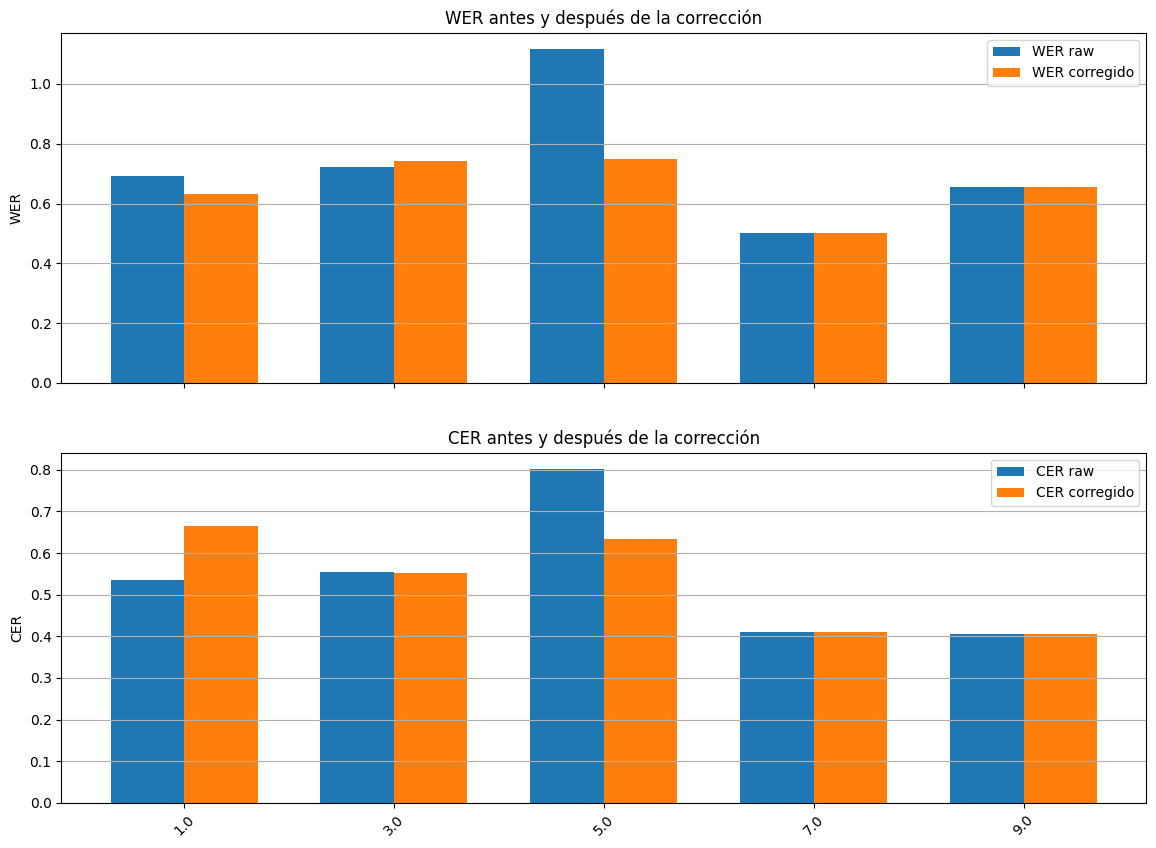

In [17]:
# Tamaños para posiciones para el eje x
x = np.arange(len(df_resultados_mejor))
# Ancho de las barras
width = 0.35  
# Crear subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
# Gráfico de barras para WER
axs[0].bar(x - width/2, df_resultados["WER_raw"], width, label="WER raw")
axs[0].bar(x + width/2, df_resultados["WER_corr"], width, label="WER corregido")
axs[0].set_ylabel("WER")
axs[0].set_title("WER antes y después de la corrección")
axs[0].legend()
axs[0].grid(axis='y')
# Gráfico de barras para CER
axs[1].bar(x - width/2, df_resultados["CER_raw"], width, label="CER raw")
axs[1].bar(x + width/2, df_resultados["CER_corr"], width, label="CER corregido")
axs[1].set_ylabel("CER")
axs[1].set_title("CER antes y después de la corrección")
axs[1].set_xticks(x)
axs[1].set_xticklabels(df_resultados["audio_id"], rotation=45)
axs[1].legend()
axs[1].grid(axis='y')

print(df_resultados_mejor)

## 5. Insights pedagógicos

In [22]:
# Lectura de datos corregidos
# dfGR_final = pd.read_csv("data/stage/transcripciones_corregidas.csv", sep=';')


# Funcion para extraer cambios
def extraer_cambios(raw, corr):
    # Devuelve la diferencia entre los dos grupos de palabras
    diff = ndiff(raw.split(), corr.split())
    # Crea lista donde deja solo los que tienen cambios
    cambios = [d for d in diff if d.startswith('- ') or d.startswith('+ ')]
    return cambios

# Guarda en lista todos los errores encontrados
errores = []
for i in range(len(dfGR_final)):
    # Aplica funcion
    cambios = extraer_cambios(dfGR_final.loc[i, "transcript_raw"], dfGR.loc[i, "transcript_raw_corr"])
    # Concatena lo encontrado
    errores.extend(cambios)
# Cuenta los elementos repetidos en lista
conteo_errores = Counter(errores)
print(conteo_errores.most_common(10))


[('+ a', 3), ('- go', 2), ('+ Tomorrow', 1), ('+ is', 1), ('- tomorrow', 1), ('- sorry', 1), ('- ahead.', 1), ('- Yeah,', 1), ('- tomorrow.', 1), ('- Tell', 1)]


In [23]:
# Diccionario para almacenar resultados
conteo = {}
for item, count in conteo_errores.items():
    tipo = item[0]  # '+' o '-'
    palabra = item[2:]  # quita el signo y espacio
    if palabra not in conteo:
        conteo[palabra] = {"# adiciones": 0, "# eliminaciones": 0}
    if tipo == '+':
        conteo[palabra]["# adiciones"] += count
    elif tipo == '-':
        conteo[palabra]["# eliminaciones"] += count
# Crear DataFrame
df = pd.DataFrame.from_dict(conteo, orient='index').reset_index()
df = df.rename(columns={"index": "palabra"})
# Crear columna de correcciones como suma de adiciones y eliminaciones
df["# correcciones"] = df["# adiciones"] + df["# eliminaciones"]
# Reorganiza columnas
df = df[["palabra", "# correcciones", "# adiciones", "# eliminaciones"]]
df = df.sort_values('# correcciones', ascending=False).reset_index(drop=True)
print(df.head())

    palabra  # correcciones  # adiciones  # eliminaciones
0         a               3            3                0
1         I               2            1                1
2        go               2            0                2
3  Tomorrow               1            1                0
4        is               1            1                0


## 6. Requiriments

In [24]:
import subprocess

# Ejecuta pip freeze y guarda la salida en requirements.txt
with open('requirements.txt', 'w') as f:
    subprocess.run(['pip', 'freeze'], stdout=f)

print("✅ Archivo requirements.txt generado con éxito.")

✅ Archivo requirements.txt generado con éxito.
